### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from keras.datasets import fashion_mnist
from keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

---
### Data ingestion

In [2]:
# Load Fashion MNIST dataset
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()

# Load Digits MNIST dataset
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


---
### Data preprocessing

``Fashion MNIST``

In [3]:
# Normalize
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

``Digits MNIST``

In [19]:
# Normalize
X_train_digits = X_train_digits / 255.
X_test_digits = X_test_digits / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

---
### Exploratory data analysis (EDA)

In [11]:
print(f"1. The first training example in X_train_fashion is\n{X_train_fashion[0,0]}\n")
print(f"2. The first training example in X_train_digits is\n{X_train_digits[0,0]}")

1. The first training example in X_train_fashion is
[0.         0.         0.00392157 0.         0.         0.00784314
 0.         0.         0.         0.         0.25490196 0.67058824
 0.59607843 0.20784314 0.18431373 0.23137255 0.24313725 0.58823529
 0.72941176 0.25882353 0.         0.         0.         0.
 0.00392157 0.00392157 0.         0.        ]

2. The first training example in X_train_digits is
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


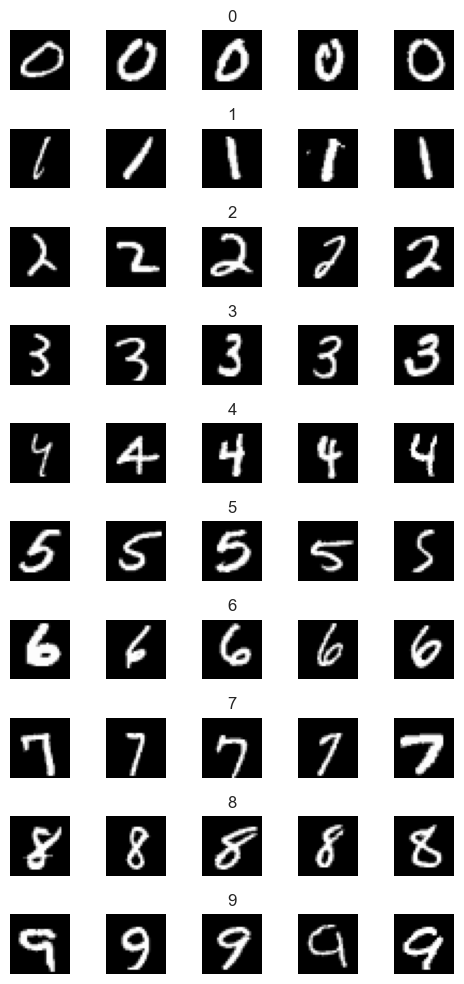

In [18]:
# Display the first 5 images in X_train_digits for each class in Y_train_digits, arranged in a 10x5 grid.

# Initiate plot
fig, ax = plt.subplots(nrows= 10, ncols= 5, figsize = (5,10))

# Find indices for each class
for label in range(10):
    idxs = np.where(Y_train_digits == label)[0][:5]
    
    # Show image for each index
    for i, idx in enumerate(idxs):
        ax[label,i].imshow(X_train_digits[idx],cmap='gray')
        ax[label, i].axis('off')
        if i == 2:  # i = 2 is when the label is centered
            ax[label, i].set_title(np.unique(Y_train_digits)[label])

# Show plot
plt.tight_layout()
plt.show()

### Build model

In [31]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='accuracy'):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    metric: The desired metric.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    
    if optimizer == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")
    
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                    activation=activation))
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax', name='Output'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics = [metric])
    return model

---
### Write train and evaluate function to experiment

/Users/jonathanho/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the digits model...


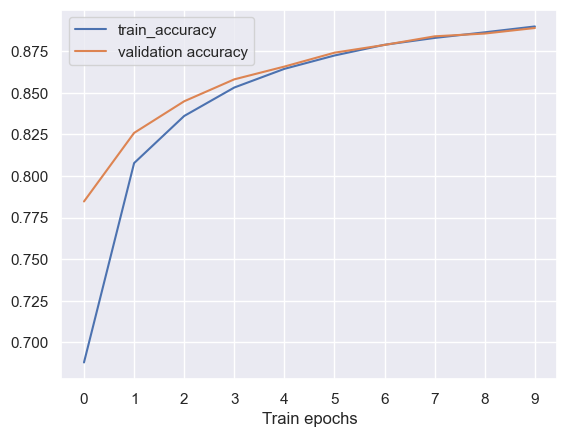

Training accuracy: 0.8898
Validation accuracy: 0.8888


In [32]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10):

  # Build the model
    model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate)

  # Select the dataset
    if data == 'digits':
        X_train = X_train_digits
        X_test = X_test_digits
        Y_train = Y_train_digits
        Y_test = Y_test_digits
    
    elif data == 'fashion':
        X_train = X_train_fashion
        X_test = X_test_fashion
        Y_train = Y_train_fashion
        Y_test = Y_test_fashion
    else:
        raise 'Unsupported dataset: %s' %data

  # Train the model
    print('Training the', data, 'model...')
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=0)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])
    
    return model


# run the function
model = train_and_evaluate()

### Ablation study

Here, we conduct experiments and record the training and validation set accuracy results in the table below

Data | Hidden sizes | Activation| Optimizer | Learning rate | #Parameters | Training accuracy| Validation accuracy
-|-|-|-|-|-|-|-
 digits | [] | tanh | SGD |0.01| 7850 | 0.1126 |0.1100
 digits | [] | relu | SGD |0.01| 7850 | 0.1126|0.1100
 digits | [] | relu | Adam |0.01| 7850 |0.8897 |0.8887
 digits | [128] | relu | Adam |0.01| 101770 |  0.9734|0.9635
 digits | [256, 128] | relu | Adam |0.01| 235146 |0.9831|0.9693
-|-|-|-|-|-|-|-
 fashion | [] | tanh | SGD |0.01| 7850 |0.8341 |0.8223
 fashion | [] | relu | SGD |0.01| 7850 | 0.8348|0.8210
 fashion | [] | relu | Adam |0.01| 7850 |0.8507 |0.8268
 fashion | [128] | relu | Adam |0.01| 101770 |0.8793 |0.8632
 fashion | [256, 128] | relu | Adam |0.01| 235146 |0.8815 |0.8557
 fashion | [128,64,32] | relu | Adam |0.007| 111146 |0.8870|0.8717

Training the digits model...


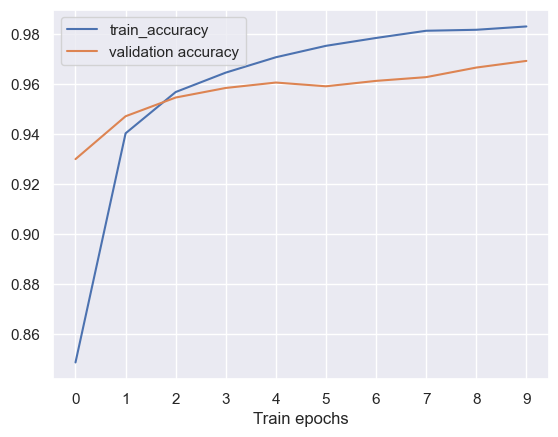

Training accuracy: 0.9831
Validation accuracy: 0.9693


In [62]:
# Best model for digits
model_digits = train_and_evaluate(data='digits',
                       hidden_layer_sizes=[256,128],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10)

/Users/jonathanho/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the fashion model...


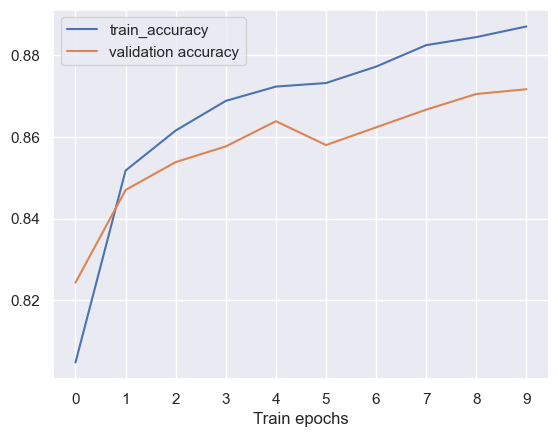

Training accuracy: 0.8870
Validation accuracy: 0.8717


In [63]:
# Best model for fashion
model_fashion = train_and_evaluate(data='fashion',
                       hidden_layer_sizes=[128,64,32],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.007,
                       metric='accuracy',
                       num_epochs=10)

---
### Evaluation and Generalization

In [69]:
# Use model.evaluate() to calculate model accuracy for digits dataset
train_loss_digits, train_accuracy_digits = model_digits.evaluate(X_train_digits, Y_train_digits, verbose=2)
print(f"Train Accuracy: {train_accuracy_digits * 100:.2f}%")

test_loss_digits, test_accuracy_digits = model_digits.evaluate(X_test_digits, Y_test_digits, verbose=2)
print(f"Test Accuracy: {test_accuracy_digits * 100:.2f}%")

1875/1875 - 1s - 386us/step - accuracy: 0.9823 - loss: 0.0560
Train Accuracy: 98.23%
313/313 - 0s - 376us/step - accuracy: 0.9700 - loss: 0.1079
Test Accuracy: 97.00%


In [81]:
# The model demonstrates strong generalization capabilities as the accuracy for the test set is close to the 
# accuracy for the training set.

In [82]:
# Use model.evaluate() to calculate model accuracy for fashion dataset
train_loss_fashion, train_accuracy_fashion = model_fashion.evaluate(X_train_fashion, Y_train_fashion, verbose=2)
print(f"Train Accuracy: {train_accuracy_fashion * 100:.2f}%")

test_loss_fashion, test_accuracy_fashion = model_fashion.evaluate(X_test_fashion, Y_test_fashion, verbose=2)
print(f"Test Accuracy: {test_accuracy_fashion * 100:.2f}%")

1875/1875 - 1s - 288us/step - accuracy: 0.8900 - loss: 0.3041
Train Accuracy: 89.00%
313/313 - 0s - 314us/step - accuracy: 0.8676 - loss: 0.3862
Test Accuracy: 86.76%


In [83]:
# The model also demonstrates strong generalization capabilities as the accuracy for the test set is close to the 
# accuracy for the training set.